*IMPORTANT NOTICE*

This notebook was developed in google colab, using the colab disk space to store data. This can manipulated using bash commands, which for convience can be operated from within the notebook and are delineated clearly with exclamation marks. (e.g ! bash command)

For the model building I used the T4 GPU on colab, the following code cell shows the details of the GPU.

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Mar 26 19:41:14 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   49C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# **Building A Convolutional Neural Network For Binary/Ternary Classification**

This notebook is the first in the development of a resilient image classifier determining the presence or absence of fire in woodland scenery. Additionally, a second network will be built to perform the ternary classification of fire, no fire or lake (or more generally a large body of water).

 The development of such networks is becoming ever more important as the abundance of forest fires has continued to increase over the past decades [1] and the effects are devastating, including habitat loss, displacement of people, financial loss and it has recently been confirmed [2] that forest fires are contributing to a significant increase in carbon emissions, which in turn has been linked to climate change in the extratropics.

 This notebook will demonstrate the iterative improvement of a baseline Convolutional Neural Network (CNN) up to a robust network architecture with high accuracy potential with built in overfitting prevention and efficiency measures. Before a new feature is added, there will be a brief theoretical explanation of its mechanism and purpose in the network.

 Despite consistent attempts to develop a one-size fits all network designing technique/algorithm, the process remains extremely open ended. There is an effectively infinite space of permutations for network design and ordering. For this reason I will define some objectives for model to make the process easier.

Objectives for network design:

    - See improvements on final loss after 20 epochs
    
    - See faster convergence to a solution

    - See appropriate overfitting prevention measures in training plots

    - Provide the network with sufficient parameters for feature extraction in images

    - Output a normalised probability of detection

## **Why CNN?**


CNNs are deep learning neural network commonly used in computer vision tasks.They can recognise patterns in training images and then make preidictions about unseen images.

As with any neural network, a CNN consists of an input layer, some hidden layers and an output layer. CNNs are Artificial Neural Neworks (ANN) which extract features from a grid shaped dataset, for example an image.

CNNs consist of an input layer, convolutional laters, pooling layers and finally some fully connected layers.



Figure 1: Overview of CNN design.

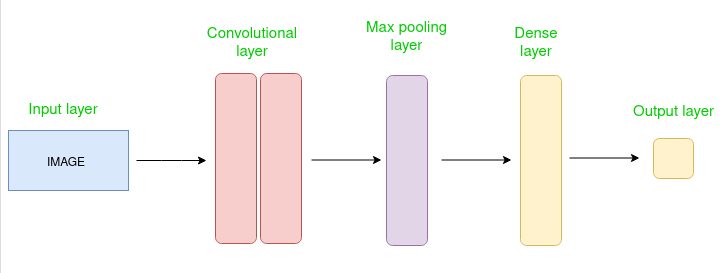

Image source: cs231n.stanford.edu

The convulational layer applies a filter of specified dimensions across the input to extract features. It scans a kernel (e.g 3x3) acorss the grid, taking the dot product between kernel weighting and the patch of input image in focus. This means the network learns the features of pixel data in the image (across the grid) and will be informed by the loss function which features are most important.

The pooling layers reduce the dimensionality of the network by condensing matrix elements scanned by the kernel in a few possible ways. One common way is to scan an n x n filter across the grid of extracted features and take the maximum values only. Another method is to take the average of all elements in the filter. This condensing reduces the number of dimensions in the network and hence the number of operations to be made at the next layer, with the intended effect of increasing efficiency.



Figure 2: Example of a maximum pooling layer.

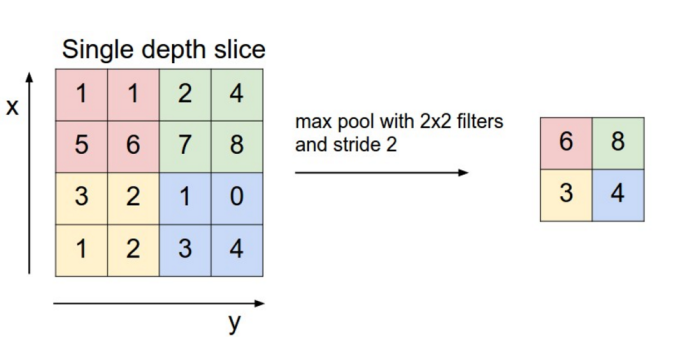

Image source: cs231n.stanford.edu

Convolutional and pooling layers can be applied to the image sequentially, reducing the dimensionality and extracting the features of the input image. The sequence of extracted values can flattened into a 1D array and then input into fully connected dense layers. The fully connected layers are typical of a neural network and will apply weights and biases to the data to finally output a single prediction value.

**Note** that each layer has a non-linear activation function applied at the end, which allows the model to learn non-linear patterns in the data, a crucial feature of any network being trained on images with complex detail and distribution of features.

Each layer (except the final dense) in the baseline has a rectified linear unit (ReLu) function applied after the weights are applied by scalar product and bias added. For binary classification, the final dense layer has a sigmoid function applied, which converts the network (1 number) output into a probability between 0 and 1. Typically, 0 is negative and 1 is positive, however due to the way colab sorts folders in its directories, 1 is Fire and 0 is no fire. For the ternary classification, a softmax function is applied to the final layer (3 numbers), converting them into probabiltities of each class.

An important point to consider is the threshold at which a network output is considered 1 or 0 (e.g is 0.4 a 1 or 0). Instinctively, one might suggest simply rounding the number, however depending on the risk factor involved with the task, this threshold might need to be non-uniform (not > 0.5 = 1 and < 0.5 = 0). For example in this task, it is riskier to have a low threshold (e.g even small values are said to be 1, no fire) because actual fire detections may be misclassified.

## Neural Network Layer Equation

A single layer in a neural network can be expressed as:

$$
\mathbf{y} = \sigma(\mathbf{W} \mathbf{x} + \mathbf{b})
$$

where:

**Input vector:**
$$
\mathbf{x} =
\begin{bmatrix}
x_1 \\
x_2 \\
\vdots \\
x_n
\end{bmatrix}
\in \mathbb{R}^{n}
$$

**Weight matrix:**
$$
\mathbf{W} =
\begin{bmatrix}
w_{11} & w_{12} & \cdots & w_{1n} \\
w_{21} & w_{22} & \cdots & w_{2n} \\
\vdots & \vdots & \ddots & \vdots \\
w_{m1} & w_{m2} & \cdots & w_{mn}
\end{bmatrix}
\in \mathbb{R}^{m \times n}
$$

**Bias vector:**
$$
\mathbf{b} =
\begin{bmatrix}
b_1 \\
b_2 \\
\vdots \\
b_m
\end{bmatrix}
\in \mathbb{R}^{m}
$$

**Output vector:**
$$
\mathbf{y} =
\begin{bmatrix}
y_1 \\
y_2 \\
\vdots \\
y_m
\end{bmatrix}
\in \mathbb{R}^{m}
$$

Each neuron computes its output as:
$$
y_i = \sigma\left( \sum_{j=1}^{n} w_{ij} x_j + b_i \right), \quad \forall i \in \{1, 2, \dots, m\}
$$

where \( $\sigma$ \) is the activation function, such as ReLU, sigmoid, or tanh.


Figure 3: ReLu activation function

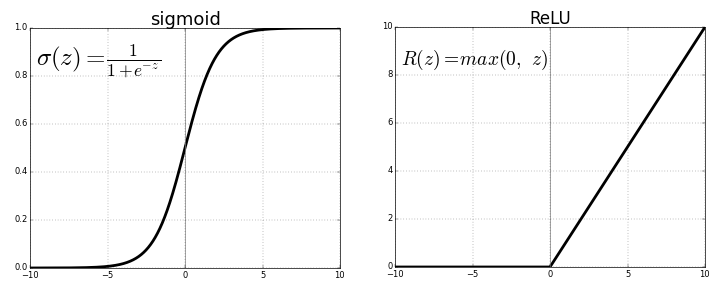

## **Data set description:**

The data used in this project comes from the FLAME dataset [3]. The images are frames from video footage taken by a drone in Arizona, USA during prescribed pile burns in woodland area (next to a large body of water). The data was provided by my university module leader in the form of a .zip file with a basic Training/Tetsing Fire/No_Fire structure. There were many issues with the dataset provided, including mislabelling and nonsensical structuring which needed to be adressed before machine learning techniques could be applied. Please see the written report for a full discussion of the dataset.

Example images will be extracted from the dataset post loading/processing.


## **Task 1: Import modules and load data**

First I must import the neccessary python modules for this task. Then I will load the raw data and manually construct the dataset, for this specific task this is a very important step, again please see the attached report for full details on this.

In [ ]:
# Import standard libraries and imageio to read in the images
import imageio.v3 as imageio

# Import numpy/itertools for array/maths calculations
import numpy as np
import itertools

# Import matplotlib to plot graphs etc.
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl

import matplotlib.cm as cm

# Import pandas to manage datasets
import pandas as pd

# Import os/path lib to navigate the colab directory.
import os
import pathlib


# Import tensorflow and keras machine learning libraries
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds

# Import scikit metrics to evaluate models
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Import google drive mounting module
from google.colab import drive





The colab notebook can be mounted onto a google drive where a .zip file containing the data is permanently stored


In [ ]:
# Mount Google Drive at the default location
drive.mount('/content/drive', force_remount=False)
# Define the path to your desired folder
path = '/content/drive/My Drive/2024-2025/PHAS0056/Code'
# Change to that directory
os.chdir(path)
# Verify the current working directory
print("Current Directory:", os.getcwd())

Mounted at /content/drive
Current Directory: /content/drive/My Drive/2024-2025/PHAS0056/Code


Now the dataset can be unzipped into the colab space for direct use by the remote GPU

In [ ]:
# Bash command to unzip the dataset
! unzip -qq fireNoFire.zip -d /data

Now I need to make a custom directory setup for the data, please see the written report for full details on this as it would be extensive to include here.

In [ ]:
# Go to the root directory
os.chdir('/')

# Create new direcory
new_dir = os.path.join(os.getcwd(), 'Binary')
os.makedirs(new_dir)

# Move to new directory
os.chdir('/Binary/')

# Create  more new direcories
new_dir = os.path.join(os.getcwd(), 'Training')
os.makedirs(new_dir)
new_dir = os.path.join(os.getcwd(), 'Test')
os.makedirs(new_dir)

# Create  more new direcories inside /Training
os.chdir('/Binary/Training')
new_dir = os.path.join(os.getcwd(), 'No_Fire')
os.makedirs(new_dir)
new_dir = os.path.join(os.getcwd(), 'Fire')
os.makedirs(new_dir)


# Create  more new direcories inside /Test
os.chdir('/Binary/Test')
new_dir = os.path.join(os.getcwd(), 'No_Fire')
os.makedirs(new_dir)
new_dir = os.path.join(os.getcwd(), 'Fire')
os.makedirs(new_dir)

In [ ]:
# Copy the data labelled as 'Fire' to the new Binary/ directory
! cp -r /data/Training/Fire/ /Binary/Training/
! cp -r /data/Test/Fire /Binary/Test/

The following cell contains seemingly odd commands because it adresses the mislabelling of images in the training/No_Fire data. I carefully take forest scenery incorrectly labelled as lake and copy into the new No_Fire/ directory in Binary/. The lake data will be utilised in the ternary task, however there is no lake images in the test set and so for the binary classification (focused on fire/no_fire), it is neccessary to remove the incorrectly labelled data. Again please see the report for a proper discussion.

*With any machine learning task there is an emphasis on making sure no test data is leaked during training, hence considerable effort was taken finding and selecting individual frames to move.*

In [ ]:
# Manually select mislabelled images and copy to the new /Binary/No_Fire directory
os.chdir('/Binary/Training/No_Fire')

!for i in {822..2257}; do cp "/data/Training/No_Fire/lake_resized_lake_frame$i.jpg" "/Binary/Training/No_Fire/lake_resized_lake_frame$((i + 1)).jpg"; done

!for i in {3353..5774}; do cp "/data/Training/No_Fire/lake_resized_lake_frame$i.jpg" "/Binary/Training/No_Fire/lake_resized_lake_frame$((i + 1)).jpg"; done

!for i in {6056..6656}; do cp "/data/Training/No_Fire/lake_resized_lake_frame$i.jpg" "/Binary/Training/No_Fire/lake_resized_lake_frame$((i + 1)).jpg"; done

!for i in {7837..7895}; do cp "/data/Training/No_Fire/lake_resized_lake_frame$i.jpg" "/Binary/Training/No_Fire/lake_resized_lake_frame$((i + 1)).jpg"; done

!for i in {10323..11293}; do cp "/data/Training/No_Fire/lake_resized_lake_frame$i.jpg" "/Binary/Training/No_Fire/lake_resized_lake_frame$((i + 1)).jpg"; done

# Copy original training no fire data to new directory
! cp /data/Training/No_Fire/resized_frame* /Binary/Training/No_Fire/
! cp -r /data/Test/No_Fire /Binary/Test/

# Copy over manually selected non-lake images labelled lake to the test set
os.chdir('/Binary/Test/No_Fire')

!for i in {11377..11846}; do cp "/data/Training/No_Fire/lake_resized_lake_frame$i.jpg" "/Binary/Test/No_Fire/lake_resized_lake_frame$((i + 1)).jpg"; done

Now the data is ready to be loaded in. In the interest of efficiency, this notebook uses Keras for nearly all functionalities, including loading data. The aptyl named "keras.utilis.image_dataset_from_directory" function allows a seamless data loading process. The training data will be split into an 80-20% split between training and validation data respectfully.

Considerations into data adjustment such as grayscaling and removing certain RGB channels will be considered, but for the purpose of model building we will stick with RBG.

In [ ]:
# A non default batch size is used to address potential data imbalances (confirmed to present later)
# Define the batch size for the dataset
batch_size = 64

# Define the raw image dimensions
img_height = 254
img_width = 254

In [ ]:
# Move to root directory and define training images path
os.chdir('/')
data_dir = pathlib.Path('Binary/Training')

# Use keras to load the raw training data, defining the validation split and assining binary labels to the data
raw_train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  labels="inferred",
  label_mode='binary',
  validation_split=0.2,
  subset="training",
  color_mode='rgb',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 33017 files belonging to 2 classes.
Using 26414 files for training.


In [ ]:
# Define the path for training images
data_dir = pathlib.Path('Binary/Training')

# Use keras to load the raw validation data, defining the validation split and assining binary labels to the data
raw_val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  labels="inferred",
  label_mode='binary',
  validation_split=0.2,
  subset="validation",
  color_mode='rgb',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 33017 files belonging to 2 classes.
Using 6603 files for validation.


In [ ]:
# Define the path for test images
data_dir = pathlib.Path('/Binary/Test')

# Use keras to load the raw test data, defining the validation split and assining binary labels to the data
raw_test_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  labels="inferred",
  label_mode='binary',
  color_mode='rgb',
  image_size=(img_height, img_width),
  batch_size=batch_size,
  shuffle=False)

Found 9087 files belonging to 2 classes.


In [ ]:
# Print the class names
class_names = raw_train_ds.class_names
print(class_names)

['Fire', 'No_Fire']


As mentioned before, because of the way colab automatically sorts file names in its disk space, Fire = 0 and No_Fire = 1

In [ ]:
# Print the number of batches for each data subset
print("Number of training batches: %d" % tf.data.experimental.cardinality(raw_train_ds))
print("Number of validation batches: %d" % tf.data.experimental.cardinality(raw_val_ds))
print("Number of test batches: %d" % tf.data.experimental.cardinality(raw_test_ds))

Number of training batches: 413
Number of validation batches: 104
Number of test batches: 142


Now that the data is loaded in, it is useful to see the balance of the dataset. Unbalanced data sets require class weighting or training biases.

For the training data:

Fire, Count: 20016
No_Fire, Count: 6398
Total Images: 26414
Percentage of images with Fire: 75.77799651699856%
Percentage of images with No Fire: 24.22200348300144%


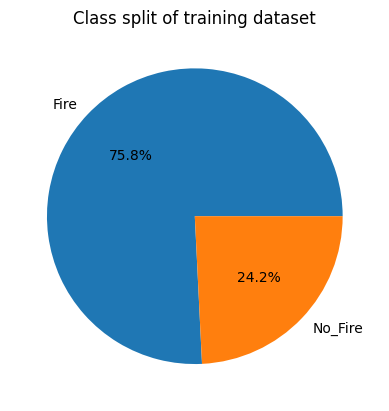

In [ ]:
# Initialize counters for both classes
Fire_count = 0
No_Fire_count = 0

# Use for loop for counting
for images, labels in raw_train_ds:
    # Convert labels to integers (0 or 1)
    labels = labels.numpy().astype(int).flatten()

    # Count how many labels are 0 and how many are 1 in the batch
    Fire_count += np.sum(labels == 0)
    No_Fire_count += np.sum(labels == 1)

# Sum the total count
Total = Fire_count + No_Fire_count

# Print out the counts
print(f"{raw_train_ds.class_names[0]}, Count: {Fire_count}")
print(f"{raw_train_ds.class_names[1]}, Count: {No_Fire_count}")
print(f"Total Images: {Total}")

# Now calculate the percentages of both classes
percent_Fire = Fire_count / Total
percent_No_Fire = No_Fire_count / Total
# Print the percentages
print(f'Percentage of images with Fire: {percent_Fire*100}%')
print(f'Percentage of images with No Fire: {percent_No_Fire*100}%')

# Creat list of percentages
sizes = [ percent_Fire,percent_No_Fire]

# Plot a pie chart of data split
plt.figure()
plt.pie(sizes,labels=class_names, autopct='%1.1f%%');
plt.title('Class split of training dataset')
plt.savefig('train_piechart.png')

For the validation data set...

Fire, Count: 5002
No_Fire, Count: 1601
Total Images: 6603
Percentage of images with Fire: 75.75%
Percentage of images with No Fire: 24.25%


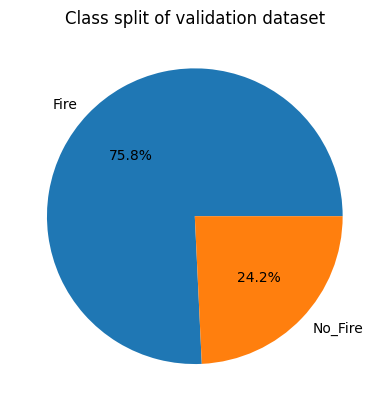

In [ ]:
# Initialize counters for both classes
Fire_count_val = 0
No_Fire_count_val = 0

# Use for loop for counting
for images, labels in raw_val_ds:
    # Convert labels to integers (0 or 1)
    labels = labels.numpy().astype(int).flatten()

    # Count how many labels are 0 and how many are 1 in the batch
    Fire_count_val += np.sum(labels == 0)
    No_Fire_count_val += np.sum(labels == 1)

# Sum the total count
Total_val = Fire_count_val + No_Fire_count_val

# Print out the counts
print(f"{raw_train_ds.class_names[0]}, Count: {Fire_count_val}")
print(f"{raw_train_ds.class_names[1]}, Count: {No_Fire_count_val}")
print(f"Total Images: {Total_val}")

# Now calculate the percentages of both classes
percent_Fire_val = Fire_count_val / (Fire_count_val + No_Fire_count_val)
percent_No_Fire_val = No_Fire_count_val / (Fire_count_val + No_Fire_count_val)

# Print the percentages
print(f'Percentage of images with Fire: {percent_Fire_val*100:.2f}%')
print(f'Percentage of images with No Fire: {percent_No_Fire_val*100:.2f}%')

# Store percentages in list
sizes_val = [ percent_Fire_val,percent_No_Fire_val]

# Plot a pie chart of data split
plt.figure()
plt.pie(sizes_val,labels=class_names, autopct='%1.1f%%');
plt.title('Class split of validation dataset')
plt.savefig('val_piechart.png')

For test data set...

Fire, Count: 5137
No_Fire, Count: 3950
Total Images: 9087
Percentage of images with Fire: 56.53130846263893%
Percentage of images with No Fire: 43.46869153736107%


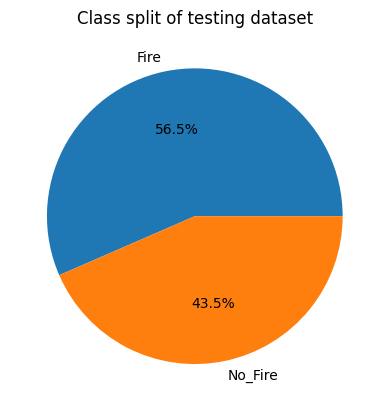

In [ ]:
# Initialize counters for both classes
Fire_count_test = 0
No_Fire_count_test = 0

# Use for loop for counting
for images, labels in raw_test_ds:
    # Convert labels to integers (0 or 1)
    labels = labels.numpy().astype(int).flatten()

    # Count how many labels are 0 and how many are 1 in the batch
    Fire_count_test += np.sum(labels == 0)
    No_Fire_count_test += np.sum(labels == 1)

# Sum the total counts
Total_test = Fire_count_test + No_Fire_count_test

# Print out the counts
print(f"{class_names[0]}, Count: {Fire_count_test}")
print(f"{class_names[1]}, Count: {No_Fire_count_test}")
print(f"Total Images: {Total_test}")

# Now calculate the percentages of both classes
percent_Fire_test = Fire_count_test / Total_test
percent_No_Fire_test = No_Fire_count_test / Total_test

# Print the percentages
print(f'Percentage of images with Fire: {percent_Fire_test*100}%')
print(f'Percentage of images with No Fire: {percent_No_Fire_test*100}%')

# Store the percentages in a list
sizes_test = [ percent_Fire_test,percent_No_Fire_test]


# Plot a pie chart of data split
plt.figure()
plt.pie(sizes_test,labels=class_names, autopct='%1.1f%%');
plt.title('Class split of testing dataset')
plt.savefig('test_piechart.png')

The training data is clearly imbalanced, to address this, class weighting will be applied during training. Another option would be to artificially generate more No_Fire images using augmentation and combine them with the data set, however this would increase the data set size and hence reduce efficiency. Conversely some fire data could be removed to create a more even balance, however it is important that the network learns as many details as possible from the available raw data, so the imbalance can simply be corrected with weighting.

I can now extract the test labels which will be useful when evaluating the models performance later on.

In [ ]:
# Create empty list to store labels
test_labels = []

# Use for loop to count
for images, labels in raw_test_ds:
    # Convert labels to integers (0 or 1)
    labels = labels.numpy().astype(int).flatten()
    # Add the labels to the list
    test_labels.extend(labels)

In [ ]:
# Print the number of testing labels
print('Number of testing images: ',len(test_labels))

Number of testing images:  9087


### **Task 2: Pre processing & Augmentation**

Before developing/testing the models, Keras has inbuilt preprocessing which can be performed to optimise efficiency. This includes prefetching the data, which means that before the next epoch, keras will start reading the data beforehand, thereby improving efficieny. Another feature is caching which loads the data set on the system RAM for faster access, however, due to the large size of the data after all preprocessing is applied, this isnt used here.

Augmentation refers to systematically applied, random operations to the data. This can include flipping images, rotation, adding noise to RBG channels etc. The intended purpose of augmentation in this network is both to reduce overfitting and also simulate real life conditions that a small drone / camera may face in real life. This reduces the specificity of the model when deployed. As with dataset description, please refer to the written report for a more rich discussion of speific augmentation used here.

Augmentation will also be used on testing data later in the project to probem the networks ability to cope with changes in weather conditions (wind, fog etc).

Add class weighting, this may need to be increased if the network struggles to learn the features of the non-dominant class.

In [ ]:
# Caclulate the weights for both classes.
weight_for_0 = (1 / Fire_count) * (Total / 2.0)
weight_for_1 = (1 / No_Fire_count) * (Total / 2.0)

# Create key-value pairs for Keras to use in training
class_weight = {0: weight_for_0, 1: weight_for_1}

# Print the class_weights
print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.66
Weight for class 1: 2.06


In [ ]:
# Use the inbuilt tensforflow optimisation algorithm for prefetching and parallel calls
AUTOTUNE = tf.data.AUTOTUNE

# Define an augmentation function
def augmentation(ds, IMG_SIZE):
    '''
    Apply data augmentation techniques to an image dataset.

    Inputs:
     ds: TensorFlow dataset, the input dataset containing images.
     IMG_SIZE: int, size to which images will be resized (not used in function but typically relevant for preprocessing).

    Returns:
     ds: TensorFlow dataset, the augmented dataset with transformations applied.
    '''

    data_augmentation = tf.keras.Sequential([
        # Randomly rotate the images between -0.5 to 0.5 times 2pi
        keras.layers.RandomRotation(0.5),
        # Randomly flip the images
        keras.layers.RandomFlip("horizontal_and_vertical"),
        # Randomly change the contrast of the images
        keras.layers.RandomContrast(0.2, value_range=(0, 255)),
        # Randomly change the brightness of images
        keras.layers.RandomBrightness(0.2, value_range=(0, 255)),
        # Randomly degenerate RGB values
        keras.layers.RandomColorDegeneration(0.2, value_range=(0, 255))
    ])

    # Apply the augmentation to the input images
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y),
                num_parallel_calls=AUTOTUNE)

    # Return augmentated data
    return ds

def prepare(ds, IMG_SIZE, shuffle=False, augment=False, resize=False):
    '''
    Prepares a TensorFlow dataset with optional shuffling, augmentation, and resizing.

    Inputs:
     ds: TensorFlow dataset, the input dataset containing images.
     IMG_SIZE: int, size to which images will be resized (if resize=True).
     shuffle: bool, whether to shuffle the dataset.
     augment: bool, whether to apply data augmentation.
     resize: bool, whether to resize images to (IMG_SIZE, IMG_SIZE).

    Returns:
     ds: TensorFlow dataset, the processed dataset with applied transformations.
    '''

    # Option to shuffle the data
    if shuffle:
        ds = ds.shuffle(reshuffle_each_iteration=True)

    # Option to augment the data
    if augment:
        ds = augmentation(ds, IMG_SIZE)

    # Option to resize the data
    if resize:
        ds = ds.map(lambda x, y: (tf.image.resize(x, (IMG_SIZE, IMG_SIZE)), y),
                    num_parallel_calls=AUTOTUNE)

    # Apply prefetching quality to the dataset
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    # Return the prepared dataset
    return ds


Now I can visualise the samples, defining a sample to increase efficiency...

In [ ]:
def visualise_samples(dataset, class_names, num_images=9, grid_size=(3, 3), figsize=(10, 10)):
    '''
    Visualises a batch of images from a TensorFlow dataset.

    Inputs:
     dataset: TensorFlow dataset, the dataset containing image-label pairs.
     class_names: list, class labels corresponding to dataset categories.
     num_images: int, number of images to display (default: 9).
     grid_size: tuple, shape of the image grid (default: (3, 3)).
     figsize: tuple, figure size for visualization (default: (10, 10)).

    Returns:
     Prints image
    '''

    #  Create figure
    plt.figure(figsize=figsize)

    # Use for loop to plot
    for images, labels in dataset.take(1):
        # For loop to take num_images
        for i in range(min(num_images, images.shape[0])):
            # Set location of plot on figure
            ax = plt.subplot(grid_size[0], grid_size[1], i + 1)
            # Display the image
            plt.imshow(images[i].numpy().astype("uint8"))
            # Add class names and remove axis
            plt.title(class_names[int(labels[i])])
            plt.axis("off")
    plt.show()


Lets see some of the training images...

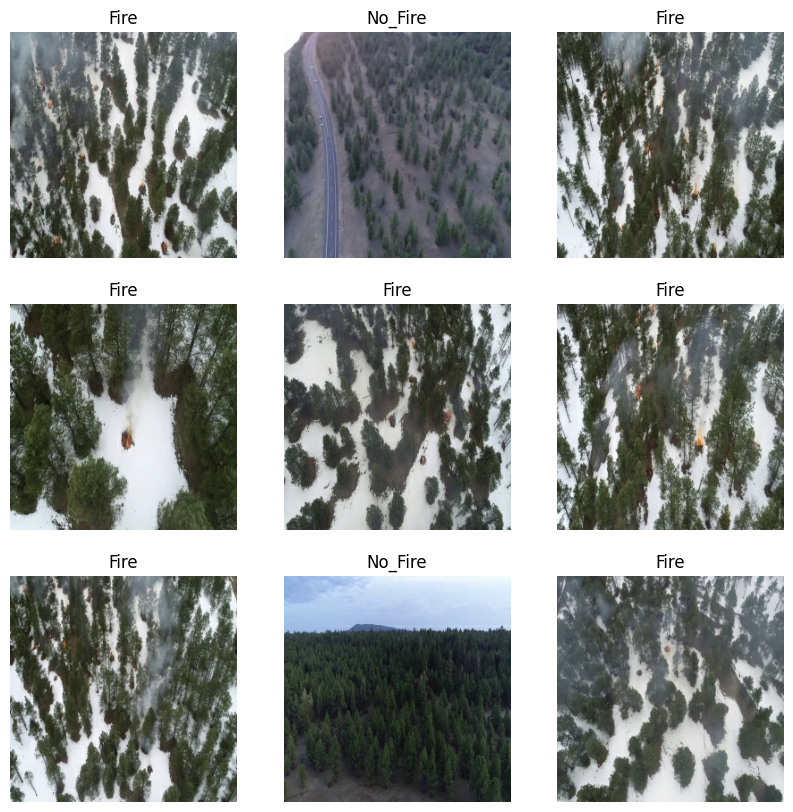

In [ ]:
visualise_samples(raw_train_ds, class_names)

Looks like it was snowy!

How about augmented data?

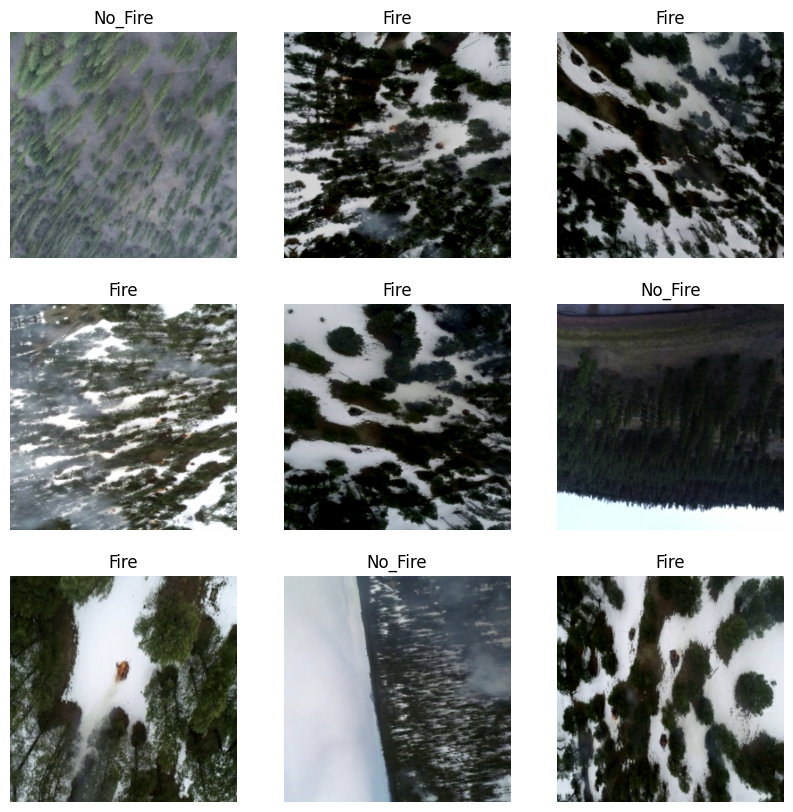

In [ ]:
IMG_SIZE = 254

aug_train_ds = prepare(raw_train_ds,IMG_SIZE,augment=True)

visualise_samples(aug_train_ds, class_names)


The images are heavily augmented, see report for further discussion.

And some of test data...

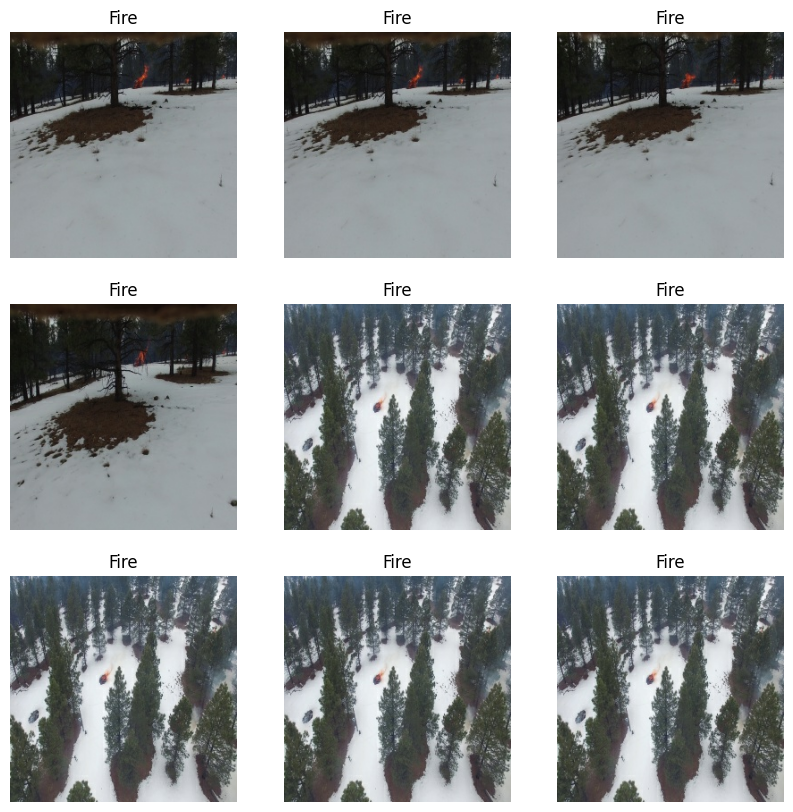

In [ ]:
visualise_samples(raw_test_ds, class_names)

Before building and training a model, functions can be implemented to improve the efficiency of training such as resetting weights and a single function which trains the model and plots the history of training.

In [ ]:
# Define function to reset weights for a model

def reset_weights(model):
    '''
    Resets the weights of a given Keras model.

    Inputs:
     model: Keras model, the model whose weights need to be reset.

    Returns:
     None (resets model weights in place).
    '''
    # Use for loop to apply to all layers in given model
    for layer in model.layers:
        # Check if the layer has weights
        if hasattr(layer, 'kernel_initializer') and hasattr(layer, 'kernel'):
            # Reset weights
            model.add_weight(name=layer.kernel.name,
                             shape=layer.kernel.shape,
                             initializer=layer.kernel_initializer)

# Define function which trains a model for n epochs with the option for class weighting

def train(model, train_ds, val_ds, epochs, class_weight=None):
    '''
    Trains a given Keras model.

    Inputs:
     model: Keras model, the model to train.
     train_ds: TensorFlow dataset, training dataset.
     val_ds: TensorFlow dataset, validation dataset.
     epochs: int, number of training epochs.
     class_weight: dict (optional), class weight mapping for handling imbalanced data.

    Returns:
     history: Keras History object, containing training metrics.
    '''

    # Option to use weighting
    if class_weight is None:
        hist = model.fit(train_ds,
                         validation_data=val_ds,
                         epochs=epochs)
    else:
        hist = model.fit(train_ds,
                         validation_data=val_ds,
                         epochs=epochs,
                         class_weight=class_weight)
    # Return training history
    return hist

def plot_training_binary_f1(history, modelname, epochs):
    '''
    Plots the training and validation F1 score and loss over epochs.

    Inputs:
     history: Keras History object, contains training metrics (loss, F1 score).
     modelname: str, name of the model (used for the plot title).
     epochs: int, number of training epochs.

    Returns:
     None (displays the plots).
    '''

    # Get losses
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    # Get F1 scores
    acc = history.history['f1_score']
    val_acc = history.history['val_f1_score']

    # Make an array from 0 to epochs
    epoch_range = range(epochs)

    # Make subplots
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    # Plot F1 Scores with title
    ax[0].plot(epoch_range, acc, label='Training F1 Score')
    ax[0].plot(epoch_range, val_acc, label='Validation F1 Score')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('F1 Score')
    ax[0].set_title('F1 Scores')
    ax[0].legend(edgecolor='1')

    # Plot losses with title
    ax[1].plot(epoch_range, loss, label='Training Loss')
    ax[1].plot(epoch_range, val_loss, label='Validation Loss')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Loss')
    ax[1].set_title('Losses')
    ax[1].legend(edgecolor='1')

    # Add title for both plots
    plt.suptitle(f'Training Metrics For {modelname}')

    # Save the plots
    plt.savefig(f'training.png')
    plt.savefig(f'training.svg')

# Define function which trains and plots history

def train_binary_f1(model, modelname, train_ds, val_ds, epochs, class_weight=None):
    '''
    Trains a binary classification model using F1 score as a key metric.

    Inputs:
     model: Keras model, the neural network to train.
     modelname: str, name of the model (used for visualization).
     train_ds: TensorFlow dataset, training dataset.
     val_ds: TensorFlow dataset, validation dataset.
     epochs: int, number of training epochs.
     class_weight: dict (optional), class weight mapping for handling imbalanced data.

    Returns:
     history: Keras History object, containing training metrics.
    '''

    # Call other functions
    history = train(model, train_ds, val_ds, epochs, class_weight)
    plot_training_binary_f1(history, modelname, epochs)

    # Return the history
    return history

And the models will be evaluated with confusion matrices and ROC curves, see report for explanation...

In [ ]:
def binary_evaluation(ds, class_names, modelname, threshold=0.5):
    '''
    Evaluates a binary classification model and displays a confusion matrix.

    Inputs:
     ds: TensorFlow dataset, dataset containing images and labels.
     class_names: list, class labels corresponding to dataset categories.
     modelname: Keras model, trained model to evaluate.
     threshold: float, decision threshold for binary classification (default: 0.5).

    Returns:
     None (prints evaluation results and displays confusion matrix).
    '''

    # Create empty list for labels
    test_labels = []

    # Collect all labels from dataset
    for images, labels in ds:
        test_labels.extend(labels.numpy())

    print("Evaluate on test data")

    # Evaluate model performance on dataset
    results = modelname.evaluate(ds, return_dict=True)
    print("Test loss, test accuracy:", results)

    # Generate predictions for the dataset
    predictions = modelname.predict(ds)

    # Apply threshold to convert probabilities into binary class labels
    predicted_classes = (predictions >= threshold).astype(int)

    # Compute confusion matrix
    cm = confusion_matrix(y_true=test_labels, y_pred=predicted_classes)

    # Display the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues)

    # Save Confusion matrix
    plt.savefig(f'Confusion.svg')


def plot_ROC_curve(modelname, test_ds, test_labels):
    '''
    Plots the ROC curve and calculates the optimal threshold using Youden's J statistic.

    Inputs:
      modelname: Keras model, the trained model to evaluate.
      test_ds: TensorFlow dataset, dataset containing test images and labels.
      test_labels: list or array, true binary labels for the test dataset.

    Returns:
      None (displays the ROC curve and prints the optimal threshold).
    '''

    # Get model predictions for the test dataset
    pred = modelname.predict(test_ds)

    # Calculate the ROC curve values (False Positive Rate, True Positive Rate, and thresholds)
    fpr, tpr, thresholds = roc_curve(test_labels, pred)

    # Calculate the Area Under the Curve (AUC)
    roc_auc = auc(fpr, tpr)

    # Plot the ROC curve
    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:0.2f})')
    plt.plot([0, 1], [0, 1], 'k--', label='No Skill')  # Diagonal line representing no skill
    plt.xlim([0.0, 1.0])  # X-axis limits (False Positive Rate)
    plt.ylim([0.0, 1.05])  # Y-axis limits (True Positive Rate)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

    # Calculate Youden's J statistic (TPR - FPR)
    J_scores = tpr - fpr

    # Find the index of the optimal threshold (maximum J score)
    optimal_idx = np.argmax(J_scores)

    # Get the optimal threshold value
    optimal_threshold = thresholds[optimal_idx]

    # Print the optimal threshold
    print("Optimal Threshold:", optimal_threshold)


### **Task 3: Model Development**

Now I can start to develop the CNN model. First I will define some hyper-parameters which I will track through development, their purpose is to track the size, efficieny and features of the network. I also need to create the datasets which will be used for training/validation. The training metrics can be define directly using Keras. For the binary classification, F1Score and AUC are used.

Avoiding overfitting is crucial in this taskk, not only because of the complex nature of the data, but because the model is intended to be deployable to a wide range of settings. This means that we want it to learn the most general features of the images, avoiding overfitting to features specific to this dataset only (e.g local geography).

### Accuracy, Precision, Recall, and F1-Score

In imbalanced datasets, **accuracy** can be misleading as it does not account for class distribution. **Precision**, **Recall**, and **F1-Score** provide a more detailed evaluation of the model's performance, particularly when classes are imbalanced.

#### 1. **Accuracy**
Accuracy is the proportion of correct predictions to total instances. It does not differentiate between error types, so it may be high even when the minority class is poorly predicted.

$$
\text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN}
$$

- **TP (True Positives)**: Correctly predicted positives.
- **TN (True Negatives)**: Correctly predicted negatives.
- **FP (False Positives)**: Negatives incorrectly classified as positives.
- **FN (False Negatives)**: Positives incorrectly classified as negatives.

In imbalanced datasets, a model predicting only the majority class can achieve high accuracy while failing to predict the minority class correctly.

#### 2. **Precision**
Precision is the proportion of true positive predictions out of all predicted positives. It answers: "Of all instances classified as positive, how many are truly positive?"

$$
\text{Precision} = \frac{TP}{TP + FP}
$$

Precision is crucial when the cost of **False Positives** is high, such as in fraud detection.

#### 3. **Recall**
Recall is the proportion of correctly predicted positives to the total actual positives. It answers: "Of all actual positives, how many were correctly identified?"

$$
\text{Recall} = \frac{TP}{TP + FN}
$$

Recall is important when **False Negatives** carry a high cost, such as in medical diagnoses where missing a positive case could have serious consequences.

#### 4. **F1-Score**
F1-Score is the harmonic mean of Precision and Recall, balancing both metrics, especially when false positives and false negatives are equally important.

$$
\text{F1-Score} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}
$$

### AUC (Area Under the Curve)

**AUC** (Area Under the ROC Curve) is another important metric for evaluating models, especially with imbalanced datasets. It measures how well the model distinguishes between classes across all thresholds.

#### 1. **What is AUC?**
AUC represents the area under the **ROC curve**, which plots the **True Positive Rate** (Recall) against the **False Positive Rate**.

AUC ranges from **0 to 1**:
- **AUC = 1**: Perfect classifier, no errors.
- **AUC = 0.5**: Model performs no better than random guessing.
- **AUC < 0.5**: Model performs worse than random guessing.

#### 2. **ROC Curve**
The **ROC curve** plots:
- **True Positive Rate (TPR)**, also known as **Recall**, on the **y-axis**:

  $$
  \text{TPR} = \frac{TP}{TP + FN}
  $$

- **False Positive Rate (FPR)** on the **x-axis**:

  $$
  \text{FPR} = \frac{FP}{FP + TN}
  $$

The ROC curve illustrates the model’s ability to discriminate between classes as the decision threshold varies.

#### 3. **Why AUC is Useful for Imbalanced Datasets**
In imbalanced datasets, **Accuracy** may be misleading as it does not reflect how well the model identifies the minority class. A model predicting the majority class can achieve high accuracy while failing to identify the minority class.

**AUC** evaluates the model’s ability to distinguish between classes across all thresholds, making it sensitive to the minority class, and is unaffected by class distribution.

#### 4. **Interpreting AUC**
- **AUC = 0.5**: Model performs no better than random guessing.
- **AUC > 0.5**: Model has some ability to discriminate between classes.
- **AUC = 1**: Perfect model with no errors.

A higher AUC indicates better performance at distinguishing between classes.

#### 5. **AUC vs Accuracy**
- **Accuracy** can be misleading in imbalanced datasets, as it does not account for the classifier's ability to identify the minority class.
- **AUC**, however, is robust to class imbalance and provides a more reliable measure of model performance, especially when the cost of misclassifying the minority class is high.

### Summary
- **AUC** assesses the overall ability of a classifier to discriminate between classes.
- Unlike **Accuracy**, **AUC** remains unaffected by class imbalance, making it a better metric for imbalanced datasets.
- **AUC = 1** indicates a perfect classifier, while **AUC = 0.5** represents a random guesser.


In [ ]:
# Prepare training/validation datasets
train_ds = prepare(raw_train_ds,IMG_SIZE,augment=True)
val_ds = prepare(raw_val_ds,IMG_SIZE)

In [ ]:
# Define metrics
METRICS = [
      keras.metrics.F1Score(name='f1_score',threshold=(0.5)),
      keras.metrics.AUC(name='auc'),
]

In [ ]:
# Increase the class weight for No_Fire
weight_for_0 = (1 / Fire_count) * (Total / 2.0)
weight_for_1 = (1 / No_Fire_count) * (Total / 2.0) * 1.5

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.66
Weight for class 1: 3.10


## **Type A Model**


This is the baseline network containing 4 convolutional layers, each with maxpooling. The data is then flattened and a 32 node dense layer connects to the final single output dense layer. Every actviation layer bar the last is ReLu. The padding used is 'same' which means that the output size of the layer is the same as the input size, so no edge features are lost. This model balances parameter count, number of operations and vastness to capture the 254x254 input images.


### Hyperparameters
- **IMG_SIZE**: 254 (Image size for input images)
- **METRICS**: F1Score, AUC (Metrics to monitor during training)

#### Model-Specific Hyperparameters:
- **CONV_FILTERS**: `[32, 64, 64, 32]` (Number of filters in Conv2D layers)
- **KERNEL_SIZE**: `3` (Size of the convolution kernel, 3x3)
- **POOL_SIZE**: `2` (Pooling factor for MaxPooling2D layers)
- **DENSE_UNITS**: `32` (Number of units in the dense layer)
- **LEARNING_RATE**: `1e-3` (Learning rate for the optimizer)
- **BATCH_SIZE**: `64` (Batch size for training)
- **EPOCHS**: `20` (Number of training epochs)
- **LAYERS**: `12` (Number of network layers)

In [ ]:
def make_model_typeA(summarise=False):
    '''
    Builds and compiles a CNN model for binary classification.

    Inputs:
      summarise: bool, whether to print the model summary (default is False).

    Returns:
      model: Compiled Keras model.
    '''
    model = keras.Sequential([
        keras.layers.Rescaling(1./255, input_shape=(IMG_SIZE, IMG_SIZE, 3)),
        keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
        keras.layers.MaxPooling2D(),
        keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
        keras.layers.MaxPooling2D(),
        keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
        keras.layers.MaxPooling2D(),
        keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
        keras.layers.MaxPooling2D(),
        keras.layers.Flatten(),
        keras.layers.Dense(32, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=METRICS
    )

    if summarise:
        model.summary()

    return model


In [ ]:
# Plot summary
modelA = make_model_typeA(1)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 254, 254, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 127, 127, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 63, 63, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 63, 63, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 31, 31, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 31, 31, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 7200)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │         230,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 305,249 (1.16 MB)

 Trainable params: 305,249 (1.16 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
413/413 ━━━━━━━━━━━━━━━━━━━━ 109s 231ms/step - auc: 0.8877 - f1_score: 0.6971 - loss: 0.4998 - val_auc: 0.9784 - val_f1_score: 0.8175 - val_loss: 0.2655
Epoch 2/20
413/413 ━━━━━━━━━━━━━━━━━━━━ 81s 193ms/step - auc: 0.9731 - f1_score: 0.8646 - loss: 0.2468 - val_auc: 0.9886 - val_f1_score: 0.8428 - val_loss: 0.2377
Epoch 3/20
413/413 ━━━━━━━━━━━━━━━━━━━━ 80s 191ms/step - auc: 0.9828 - f1_score: 0.8877 - loss: 0.1957 - val_auc: 0.9927 - val_f1_score: 0.8289 - val_loss: 0.2574
Epoch 4/20
413/413 ━━━━━━━━━━━━━━━━━━━━ 80s 189ms/step - auc: 0.9890 - f1_score: 0.9015 - loss: 0.1599 - val_auc: 0.9968 - val_f1_score: 0.9194 - val_loss: 0.1257
Epoch 5/20
413/413 ━━━━━━━━━━━━━━━━━━━━ 80s 191ms/step - auc: 0.9939 - f1_score: 0.9270 - loss: 0.1178 - val_auc: 0.9975 - val_f1_score: 0.9614 - val_loss: 0.0549
Epoch 6/20
413/413 ━━━━━━━━━━━━━━━━━━━━ 80s 191ms/step - auc: 0.9954 - f1_score: 0.9348 - loss: 0.1007 - val_auc: 0.9988 - val_f1_score: 0.9451 - val_loss: 0.0701
Epoch 7/20
413/413 ━━

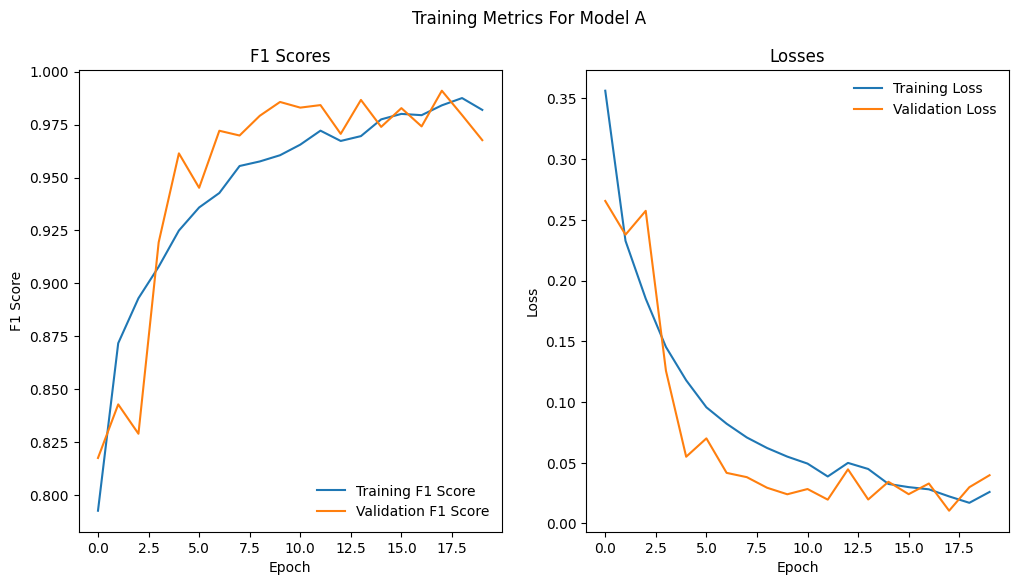

In [ ]:
# Train the model and plot history
history_A = train_binary_f1(modelA,'Model A',train_ds,val_ds,20,class_weight)

The model trains well within 20 epochs, however because of the complexity of this task, features must be introduced to prevent overfitting.

Evaluate on test data
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - auc: 0.2600 - f1_score: 0.1175 - loss: 0.6796
test loss, test acc: {'auc': 0.6521350145339966, 'f1_score': 0.4455396234989166, 'loss': 1.1605207920074463}
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step


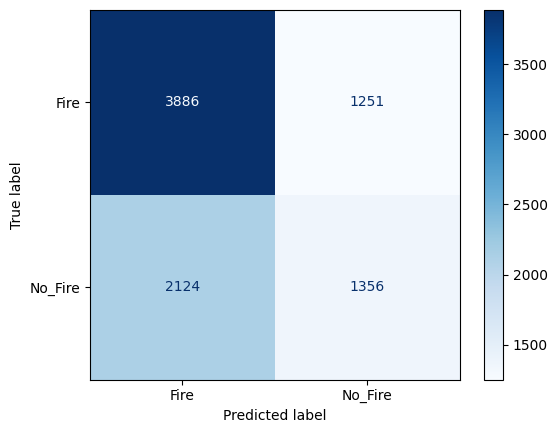

In [ ]:
binary_evaluation(raw_test_ds,class_names,modelA,0.5)

With a standard 0.5 threshold, the model is clearly predicting the majority class more often. This implies the need for regularisation techniques to prevent overfitting.

68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step


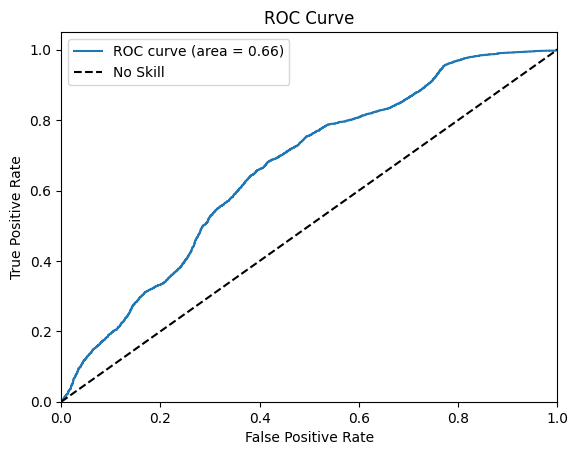

Optimal Threshold: 0.08114817


In [ ]:
plot_ROC_curve(modelA,raw_test_ds,test_labels)

## **Type B Model**

To reduce the risk of overfitting batch normalisation can be added to the network. It normalizes the inputs of each layer by standardizing the activations of the previous layer across mini-batches. A batch normalisation layer applies a transformation that maintains the mean output near 0 and the output standard deviation close to 1.

#### Why is it good?
- **Stabilizes Training:** Reduces internal covariate shift, making training faster and more stable.
- **Improves Convergence:** Allows the use of higher learning rates, speeding up the training process.
- **Reduces Overfitting:** Acts as a form of regularisation, reducing the need for dropout.

### Hyperparameters
- **IMG_SIZE**: 254 (Image size for input images)
- **METRICS**: F1Score, AUC (Metrics to monitor during training)

#### Model-Specific Hyperparameters:
- **CONV_FILTERS**: `[32, 64, 64, 32]` (Number of filters in Conv2D layers)
- **KERNEL_SIZE**: `3` (Size of the convolution kernel, 3x3)
- **POOL_SIZE**: `2` (Pooling factor for MaxPooling2D layers)
- **DENSE_UNITS**: `32` (Number of units in the dense layer)
- **LEARNING_RATE**: `1e-3` (Learning rate for the optimizer)
- **BATCH_SIZE**: `64` (Batch size for training)
- **EPOCHS**: `20` (Number of training epochs)
- **LAYERS**: `16` (Number of network layers)

In [ ]:

def make_model_typeB(summarise='False'):
    '''
    Builds and compiles a CNN model for binary classification.

    Inputs:
      summarise: bool, whether to print the model summary (default is False).

    Returns:
      model: Compiled Keras model.
    '''
    model = keras.Sequential([
      keras.layers.Rescaling(1./255, input_shape=(IMG_SIZE, IMG_SIZE, 3)),
      keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
      keras.layers.BatchNormalization(),
      keras.layers.MaxPooling2D(),
      keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
      keras.layers.BatchNormalization(),
      keras.layers.MaxPooling2D(),
      keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
      keras.layers.BatchNormalization(),
      keras.layers.MaxPooling2D(),
      keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
      keras.layers.BatchNormalization(),
      keras.layers.MaxPooling2D(),
      keras.layers.Flatten(),
      keras.layers.Dense(32,activation='relu'),
      keras.layers.Dense(1, activation='sigmoid')
     ])

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=METRICS)

    if summarise == 1:
      model.summary()
      return model
    else:
     return model


In [ ]:
modelB = make_model_typeB(1)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)              │ (None, 254, 254, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 254, 254, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 127, 127, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 127, 127, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 63, 63, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 63, 63, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 63, 63, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 31, 31, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 31, 31, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 31, 31, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 7200)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │         230,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 306,017 (1.17 MB)

 Trainable params: 305,633 (1.17 MB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/20
413/413 ━━━━━━━━━━━━━━━━━━━━ 90s 197ms/step - auc: 0.8655 - f1_score: 0.7704 - loss: 0.3629 - val_auc: 0.9359 - val_f1_score: 0.6796 - val_loss: 0.6643
Epoch 2/20
413/413 ━━━━━━━━━━━━━━━━━━━━ 80s 190ms/step - auc: 0.9945 - f1_score: 0.9210 - loss: 0.1135 - val_auc: 0.9771 - val_f1_score: 0.6034 - val_loss: 0.8592
Epoch 3/20
413/413 ━━━━━━━━━━━━━━━━━━━━ 80s 191ms/step - auc: 0.9966 - f1_score: 0.9455 - loss: 0.0835 - val_auc: 0.9746 - val_f1_score: 0.8544 - val_loss: 0.2906
Epoch 4/20
413/413 ━━━━━━━━━━━━━━━━━━━━ 81s 193ms/step - auc: 0.9984 - f1_score: 0.9660 - loss: 0.0499 - val_auc: 0.9422 - val_f1_score: 0.8409 - val_loss: 0.3250
Epoch 5/20
413/413 ━━━━━━━━━━━━━━━━━━━━ 80s 191ms/step - auc: 0.9985 - f1_score: 0.9703 - loss: 0.0430 - val_auc: 0.9781 - val_f1_score: 0.6018 - val_loss: 0.8564
Epoch 6/20
413/413 ━━━━━━━━━━━━━━━━━━━━ 81s 193ms/step - auc: 0.9985 - f1_score: 0.9721 - loss: 0.0418 - val_auc: 0.9988 - val_f1_score: 0.9668 - val_loss: 0.0475
Epoch 7/20
413/413 ━━━

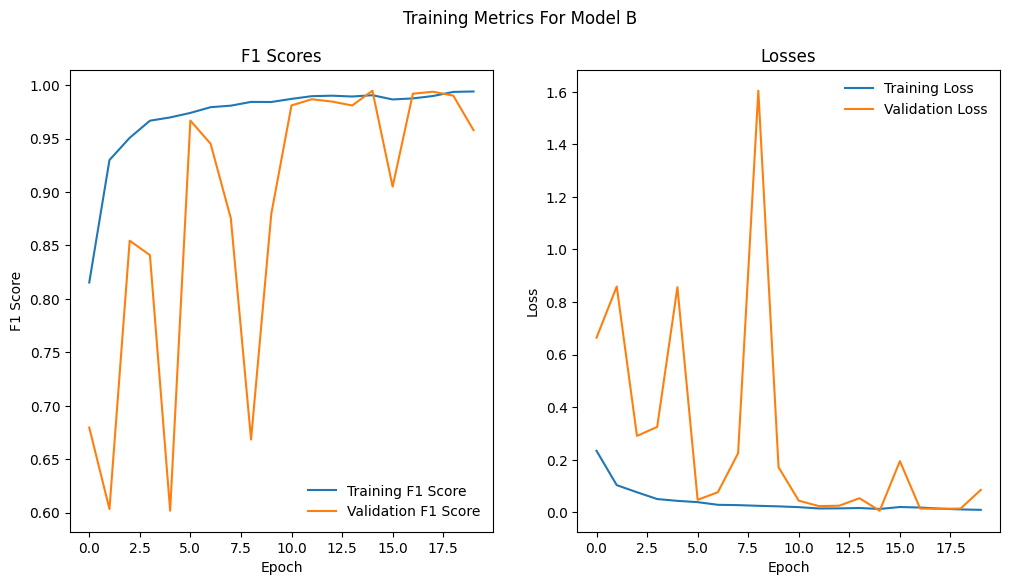

In [ ]:
history_B = train_binary_f1(modelB,'Model B',train_ds,val_ds,20,class_weight)

Within 20 epochs this model has brought us closer to the objectives define in the beggining, a smaller fina loss, signs of overfitting prevention (large jumps in validation scores/loss despite convergence). The model also converges to a solution quicker.

Evaluate on test data
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - auc: 0.2740 - f1_score: 0.1789 - loss: 1.8568
test loss, test acc: {'auc': 0.6568789482116699, 'f1_score': 0.6028777956962585, 'loss': 1.7340861558914185}
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step


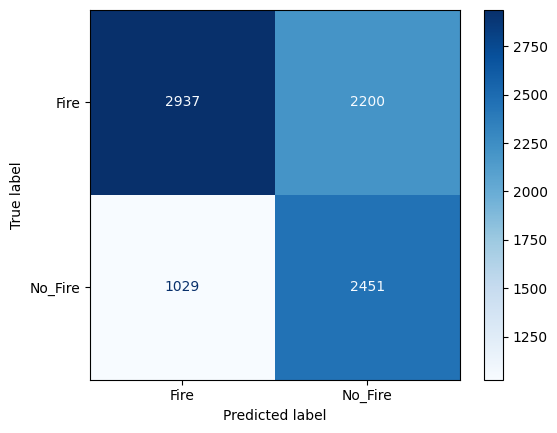

In [ ]:
binary_evaluation(raw_test_ds,class_names,modelB,0.5)

Now it appears that model is favouring the minority class, likely because batch normalisation has reduced the disparity in features of a no fire / fire image, however dropout can be used to prevent this overfitting of one class.

68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step


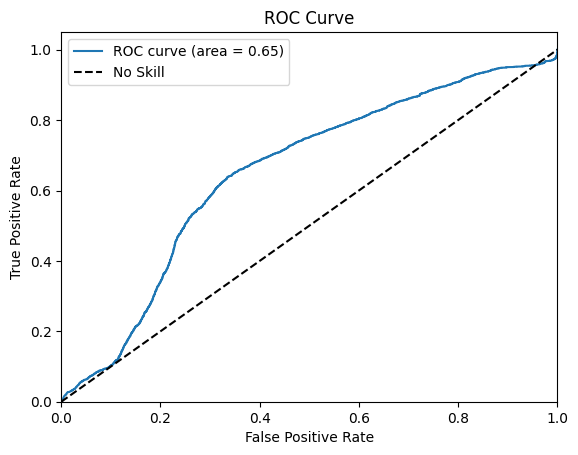

Optimal Threshold: 0.71668494


In [ ]:
plot_ROC_curve(modelB,raw_test_ds,test_labels)

## **Type C Model**

When the model is trained on a large number of epochs, the potential for overfitting is high. Henceforth, we can introduce a dropout layer into the network. A dropout rate of 0.2 (20%) means that 20% of weights are randomly set to zero (deactivated), which should prevent overfitting from occuring during training.

### Hyperparameters
- **IMG_SIZE**: 254 (Image size for input images)
- **METRICS**: F1Score, AUC (Metrics to monitor during training)

#### Model-Specific Hyperparameters:
- **CONV_FILTERS**: `[32, 64, 64, 32]` (Number of filters in Conv2D layers)
- **KERNEL_SIZE**: `3` (Size of the convolution kernel, 3x3)
- **POOL_SIZE**: `2` (Pooling factor for MaxPooling2D layers)
- **DENSE_UNITS**: `32` (Number of units in the dense layer)
- **LEARNING_RATE**: `1e-3` (Learning rate for the optimizer)
- **BATCH_SIZE**: `64` (Batch size for training)
- **EPOCHS**: `20` (Number of training epochs)
- **LAYERS**: `17` (Number of network layers)

In [ ]:

def make_model_typeC(summarise='False'):
    '''
    Builds and compiles a CNN model for binary classification.

    Inputs:
     summarise: str or bool, whether to print the model summary (default is 'False').

    Returns:
     model: Compiled Keras model.
    '''
    model = keras.Sequential([
      keras.layers.Rescaling(1./255, input_shape=(IMG_SIZE, IMG_SIZE, 3)),
      keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
      keras.layers.BatchNormalization(),
      keras.layers.MaxPooling2D(),
      keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
      keras.layers.BatchNormalization(),
      keras.layers.MaxPooling2D(),
      keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
      keras.layers.BatchNormalization(),
      keras.layers.MaxPooling2D(),
      keras.layers.Flatten(),
      keras.layers.Dense(32,activation='relu'),
      keras.layers.Dropout(0.2),
      keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=METRICS)

    if summarise == 1:
     model.summary()
     return model
    else:
     return model


In [ ]:
model_C = make_model_typeC(1)

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)              │ (None, 254, 254, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 254, 254, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 127, 127, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 127, 127, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 63, 63, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 63, 63, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 63, 63, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 31, 31, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 30752)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │         984,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,022,497 (3.90 MB)

 Trainable params: 1,022,241 (3.90 MB)

 Non-trainable params: 256 (1.00 KB)

Epoch 1/20
413/413 ━━━━━━━━━━━━━━━━━━━━ 90s 198ms/step - auc: 0.9720 - f1_score: 0.8506 - loss: 0.5879 - val_auc: 0.7483 - val_f1_score: 0.4322 - val_loss: 4.5283
Epoch 2/20
413/413 ━━━━━━━━━━━━━━━━━━━━ 80s 189ms/step - auc: 0.9703 - f1_score: 0.8762 - loss: 0.2610 - val_auc: 0.9477 - val_f1_score: 0.6879 - val_loss: 0.9641
Epoch 3/20
413/413 ━━━━━━━━━━━━━━━━━━━━ 80s 190ms/step - auc: 0.9834 - f1_score: 0.8956 - loss: 0.1991 - val_auc: 0.9683 - val_f1_score: 0.8258 - val_loss: 0.1978
Epoch 4/20
413/413 ━━━━━━━━━━━━━━━━━━━━ 79s 189ms/step - auc: 0.9877 - f1_score: 0.9111 - loss: 0.1680 - val_auc: 0.9581 - val_f1_score: 0.8851 - val_loss: 0.2674
Epoch 5/20
413/413 ━━━━━━━━━━━━━━━━━━━━ 79s 188ms/step - auc: 0.9915 - f1_score: 0.9210 - loss: 0.1412 - val_auc: 0.7225 - val_f1_score: 0.5829 - val_loss: 0.6591
Epoch 6/20
413/413 ━━━━━━━━━━━━━━━━━━━━ 79s 189ms/step - auc: 0.9896 - f1_score: 0.9159 - loss: 0.1632 - val_auc: 0.9951 - val_f1_score: 0.9323 - val_loss: 0.0819
Epoch 7/20
413/413 ━━━

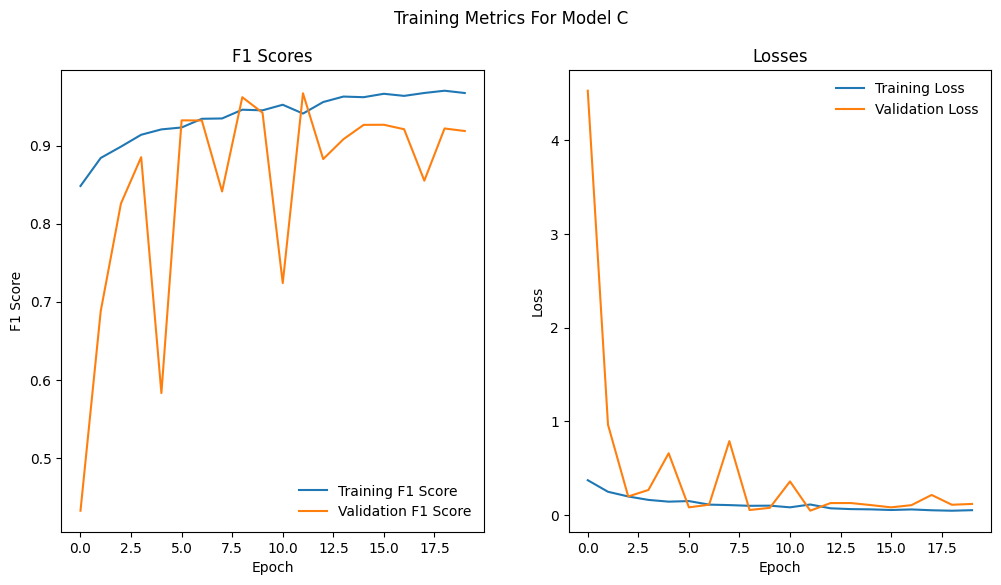

In [ ]:
history_C = train_binary_f1(model_C,'Model C',train_ds,val_ds,20,class_weight)

The addition of dropout has slightly degraded the convergence within 20 epochs, with a larger final loss. However this is expected with dropout and the model still converges faster than before so this is an improvement overall. Removing one convolutional layer did not appear to improve training efficiency, therefore it will return in next iteration.

In [ ]:
binary_evaluation(raw_test_ds,class_names,model_C,0.5)

68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step


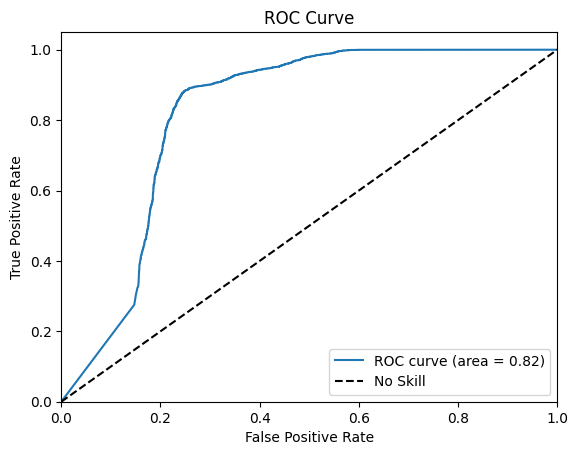

Optimal Threshold: 0.9592486


In [ ]:
plot_ROC_curve(model_C,raw_test_ds,test_labels)

The improvement is more clearly seen here, where see that AUC value has increased despite the final loss being higher. This demonstrates how relying on a single paramteter during training can be misleading.

Evaluate on test data
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - auc: 0.3589 - f1_score: 0.2264 - loss: 4.1180
test loss, test acc: {'auc': 0.8445174098014832, 'f1_score': 0.7242814898490906, 'loss': 3.5829474925994873}
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step


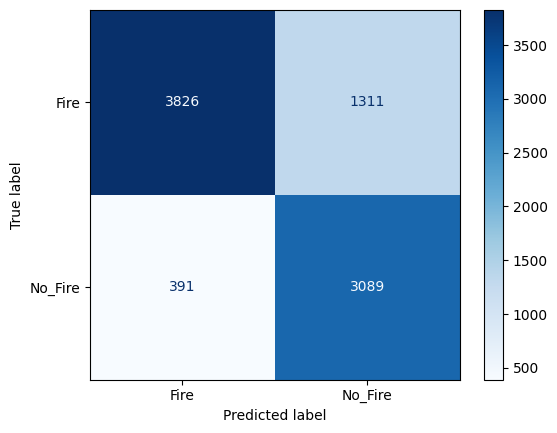

In [ ]:
binary_evaluation(raw_test_ds,class_names,model_C,0.95)

## **Type D Model**

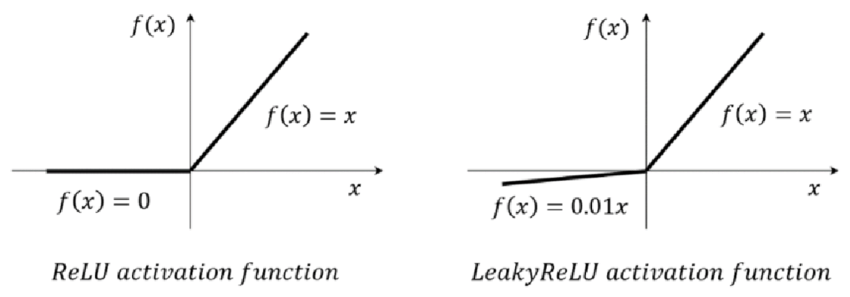

### Why Use Leaky ReLU?

**Leaky ReLU** is an activation function that improves on standard **ReLU** by allowing small negative values for inputs below zero, preventing neurons from becoming inactive.

#### **1. The Dying ReLU Problem**
ReLU is defined as:
\[
f(x) = \max(0, x)
\]
For \( x > 0 \), it behaves linearly, but for \( x \leq 0 \), it outputs **zero**, meaning neurons receiving only negative inputs can stop learning (zero gradient).

#### **2. Leaky ReLU Solution**
Leaky ReLU modifies ReLU by introducing a small negative slope \( \alpha \) for \( x \leq 0 \):
\[
f(x) =
\begin{cases}
x, & x > 0 \\
\alpha x, & x \leq 0
\end{cases}
\]
where \( \alpha \) is typically 0.01.

#### **3. Advantages of Leaky ReLU**
- **Prevents dying neurons** (ensures all neurons contribute to learning).
- **Maintains non-linearity**, improving deep network performance.


### Hyperparameters
- **IMG_SIZE**: 254 (Image size for input images)
- **METRICS**: F1Score, AUC (Metrics to monitor during training)

#### Model-Specific Hyperparameters:
- **CONV_FILTERS**: `[32, 64, 64, 32]` (Number of filters in Conv2D layers)
- **KERNEL_SIZE**: `3` (Size of the convolution kernel, 3x3)
- **POOL_SIZE**: `2` (Pooling factor for MaxPooling2D layers)
- **DENSE_UNITS**: `32` (Number of units in the dense layer)
- **LEARNING_RATE**: `1e-3` (Learning rate for the optimizer)
- **BATCH_SIZE**: `64` (Batch size for training)
- **EPOCHS**: `20` (Number of training epochs)
- **LAYERS**: `21` (Number of network layers)

In [ ]:

def make_model_typeD(summarise='False'):
    '''
    Builds and compiles a CNN model for binary classification.

    Inputs:
     summarise: str or bool, whether to print the model summary (default is 'False').

    Returns:
     model: Compiled Keras model.
    '''
    model = keras.Sequential([
      keras.layers.Rescaling(1./255, input_shape=(IMG_SIZE, IMG_SIZE, 3)),
      keras.layers.Conv2D(32, 3, padding='same'),
      keras.layers.LeakyReLU(),
      keras.layers.BatchNormalization(),
      keras.layers.MaxPooling2D(),
      keras.layers.Conv2D(64, 3, padding='same'),
      keras.layers.LeakyReLU(),
      keras.layers.BatchNormalization(),
      keras.layers.MaxPooling2D(),
      keras.layers.Conv2D(64, 3, padding='same'),
      keras.layers.LeakyReLU(),
      keras.layers.BatchNormalization(),
      keras.layers.MaxPooling2D(),
      keras.layers.Conv2D(32, 3, padding='same'),
      keras.layers.LeakyReLU(),
      keras.layers.BatchNormalization(),
      keras.layers.MaxPooling2D(),
      keras.layers.Flatten(),
      keras.layers.Dense(32),
      keras.layers.LeakyReLU(),
      keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=METRICS)

    if summarise == 1:
      model.summary()
      return model
    else:
      return model


In [ ]:
model_D = make_model_typeD(1)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential_30"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_30 (Rescaling)             │ (None, 254, 254, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_111 (Conv2D)                  │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_5 (LeakyReLU)            │ (None, 254, 254, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_100              │ (None, 254, 254, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_108 (MaxPooling2D)     │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_112 (Conv2D)                  │ (None, 127, 127, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_6 (LeakyReLU)            │ (None, 127, 127, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_101              │ (None, 127, 127, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_109 (MaxPooling2D)     │ (None, 63, 63, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_113 (Conv2D)                  │ (None, 63, 63, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_7 (LeakyReLU)            │ (None, 63, 63, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_102              │ (None, 63, 63, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_110 (MaxPooling2D)     │ (None, 31, 31, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_114 (Conv2D)                  │ (None, 31, 31, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_8 (LeakyReLU)            │ (None, 31, 31, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_103              │ (None, 31, 31, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_111 (MaxPooling2D)     │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_27 (Flatten)                 │ (None, 7200)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_54 (Dense)                     │ (None, 32)                  │         230,432 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 306,017 (1.17 MB)

 Trainable params: 305,633 (1.17 MB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 70s 341ms/step - auc: 0.9131 - f1_score: 0.4267 - loss: 1.0017 - val_auc: 0.6530 - val_f1_score: 0.1683 - val_loss: 0.9986
Epoch 2/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 61s 340ms/step - auc: 0.9800 - f1_score: 0.7250 - loss: 0.2176 - val_auc: 0.5396 - val_f1_score: 0.1440 - val_loss: 2.6136
Epoch 3/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 61s 337ms/step - auc: 0.9913 - f1_score: 0.8214 - loss: 0.1225 - val_auc: 0.9913 - val_f1_score: 0.5677 - val_loss: 0.3718
Epoch 4/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 61s 337ms/step - auc: 0.9947 - f1_score: 0.8662 - loss: 0.0891 - val_auc: 0.6655 - val_f1_score: 0.1701 - val_loss: 6.1290
Epoch 5/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 61s 337ms/step - auc: 0.9956 - f1_score: 0.8817 - loss: 0.0773 - val_auc: 0.7855 - val_f1_score: 0.5459 - val_loss: 0.4412
Epoch 6/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 61s 336ms/step - auc: 0.9973 - f1_score: 0.9089 - loss: 0.0549 - val_auc: 0.9345 - val_f1_score: 0.7477 - val_loss: 0.1574
Epoch 7/20
173/173 ━━━

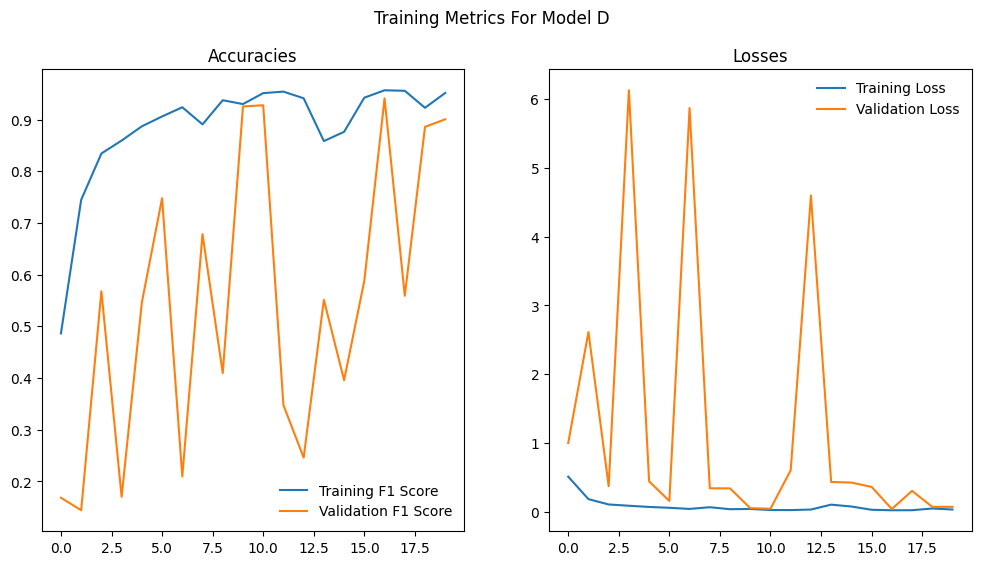

In [ ]:
history_D = train_binary_f1(model_D,'Model D',train_ds,val_ds,20,class_weight)

Evaluate on test data
68/68 ━━━━━━━━━━━━━━━━━━━━ 6s 86ms/step - auc: 0.3214 - f1_score: 0.1912 - loss: 0.9858
test loss, test acc: {'auc': 0.792060911655426, 'f1_score': 0.6305168867111206, 'loss': 1.4577467441558838}
68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step


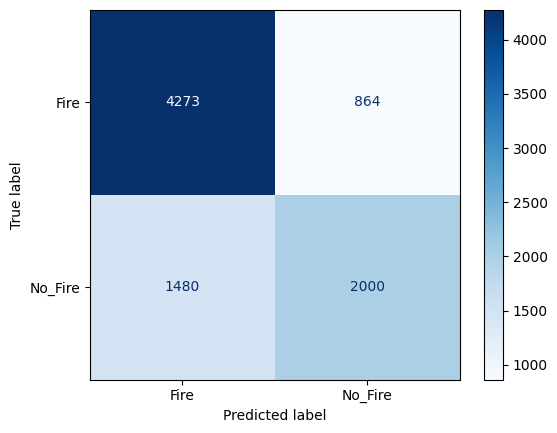

In [ ]:
binary_evaluation(raw_test_ds,class_names,model_D,0.5)

68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step


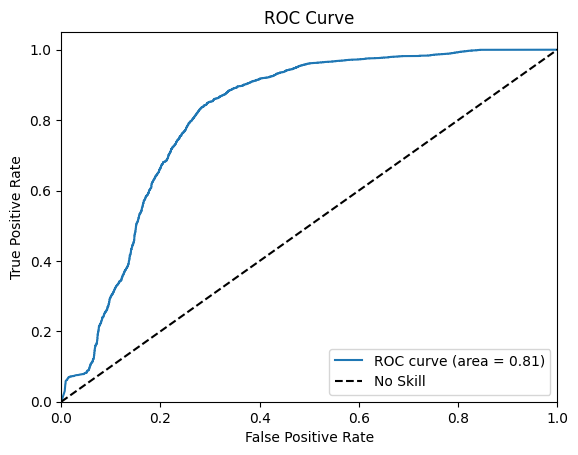

Optimal Threshold: 0.009148677


In [ ]:
plot_ROC_curve(model_D,raw_test_ds,test_labels)

Evaluate on test data
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - auc: 0.3214 - f1_score: 0.1912 - loss: 0.9858
test loss, test acc: {'auc': 0.792060911655426, 'f1_score': 0.6305168867111206, 'loss': 1.4577467441558838}
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step


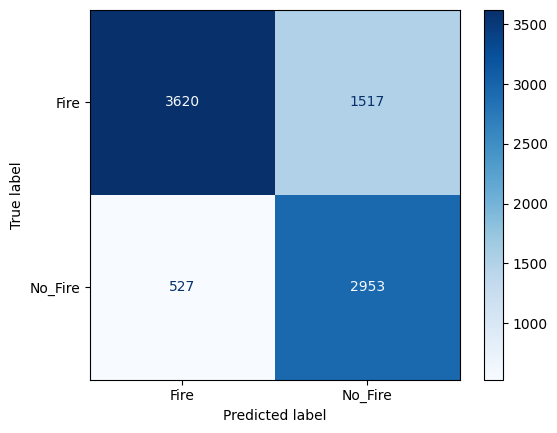

In [ ]:
binary_evaluation(raw_test_ds,class_names,model_D,0.009)

## **Type E**

The final model combines LeakyReLu and dropout.

### Hyperparameters
- **IMG_SIZE**: 254 (Image size for input images)
- **METRICS**: F1Score, AUC (Metrics to monitor during training)

#### Model-Specific Hyperparameters:
- **CONV_FILTERS**: `[32, 64, 64, 32]` (Number of filters in Conv2D layers)
- **KERNEL_SIZE**: `3` (Size of the convolution kernel, 3x3)
- **POOL_SIZE**: `2` (Pooling factor for MaxPooling2D layers)
- **DENSE_UNITS**: `32` (Number of units in the dense layer)
- **LEARNING_RATE**: `1e-3` (Learning rate for the optimizer)
- **BATCH_SIZE**: `64` (Batch size for training)
- **EPOCHS**: `20` (Number of training epochs)
- **LAYERS**: `22` (Number of network layers)

In [ ]:

def make_model_typeE(summarise='False'):
    '''
    Builds and compiles a CNN model for binary classification.

    Inputs:
     summarise: str or bool, whether to print the model summary (default is 'False').

    Returns:
     model: Compiled Keras model.
    '''
    model = keras.Sequential([
      keras.layers.Rescaling(1./255, input_shape=(IMG_SIZE, IMG_SIZE, 3)),
      keras.layers.Conv2D(32, 3, padding='same'),
      keras.layers.LeakyReLU(),
      keras.layers.BatchNormalization(),
      keras.layers.MaxPooling2D(),
      keras.layers.Conv2D(64, 3, padding='same'),
      keras.layers.LeakyReLU(),
      keras.layers.BatchNormalization(),
      keras.layers.MaxPooling2D(),
      keras.layers.Conv2D(64, 3, padding='same'),
      keras.layers.LeakyReLU(),
      keras.layers.BatchNormalization(),
      keras.layers.MaxPooling2D(),
      keras.layers.Conv2D(32, 3, padding='same'),
      keras.layers.LeakyReLU(),
      keras.layers.BatchNormalization(),
      keras.layers.MaxPooling2D(),
      keras.layers.Flatten(),
      keras.layers.Dense(32),
      keras.layers.LeakyReLU(),
      keras.layers.Dropout(0.2),
      keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=METRICS)

    if summarise == 1:
      model.summary()
      return model
    else:
      return model


In [ ]:
model_E = make_model_typeE(1)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential_32"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_32 (Rescaling)             │ (None, 254, 254, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_119 (Conv2D)                  │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_15 (LeakyReLU)           │ (None, 254, 254, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_108              │ (None, 254, 254, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_116 (MaxPooling2D)     │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_120 (Conv2D)                  │ (None, 127, 127, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_16 (LeakyReLU)           │ (None, 127, 127, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_109              │ (None, 127, 127, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_117 (MaxPooling2D)     │ (None, 63, 63, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_121 (Conv2D)                  │ (None, 63, 63, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_17 (LeakyReLU)           │ (None, 63, 63, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_110              │ (None, 63, 63, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_118 (MaxPooling2D)     │ (None, 31, 31, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_122 (Conv2D)                  │ (None, 31, 31, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_18 (LeakyReLU)           │ (None, 31, 31, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_111              │ (None, 31, 31, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_119 (MaxPooling2D)     │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_29 (Flatten)                 │ (None, 7200)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_27 (Dropout)                 │ (None, 7200)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 306,017 (1.17 MB)

 Trainable params: 305,633 (1.17 MB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 73s 345ms/step - auc: 0.9493 - f1_score: 0.5925 - loss: 0.9472 - val_auc: 0.7610 - val_f1_score: 0.1678 - val_loss: 2.9963
Epoch 2/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 61s 339ms/step - auc: 0.9860 - f1_score: 0.7587 - loss: 0.1692 - val_auc: 0.7801 - val_f1_score: 0.1872 - val_loss: 2.4820
Epoch 3/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 61s 339ms/step - auc: 0.9921 - f1_score: 0.8282 - loss: 0.1100 - val_auc: 0.9514 - val_f1_score: 0.5248 - val_loss: 0.3246
Epoch 4/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 61s 338ms/step - auc: 0.9943 - f1_score: 0.8677 - loss: 0.0914 - val_auc: 0.9855 - val_f1_score: 0.4913 - val_loss: 0.4442
Epoch 5/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 61s 338ms/step - auc: 0.9954 - f1_score: 0.8710 - loss: 0.0816 - val_auc: 0.6303 - val_f1_score: 0.1663 - val_loss: 4.9009
Epoch 6/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 61s 338ms/step - auc: 0.9958 - f1_score: 0.8798 - loss: 0.0715 - val_auc: 0.7645 - val_f1_score: 0.3414 - val_loss: 0.5134
Epoch 7/20
173/173 ━━━

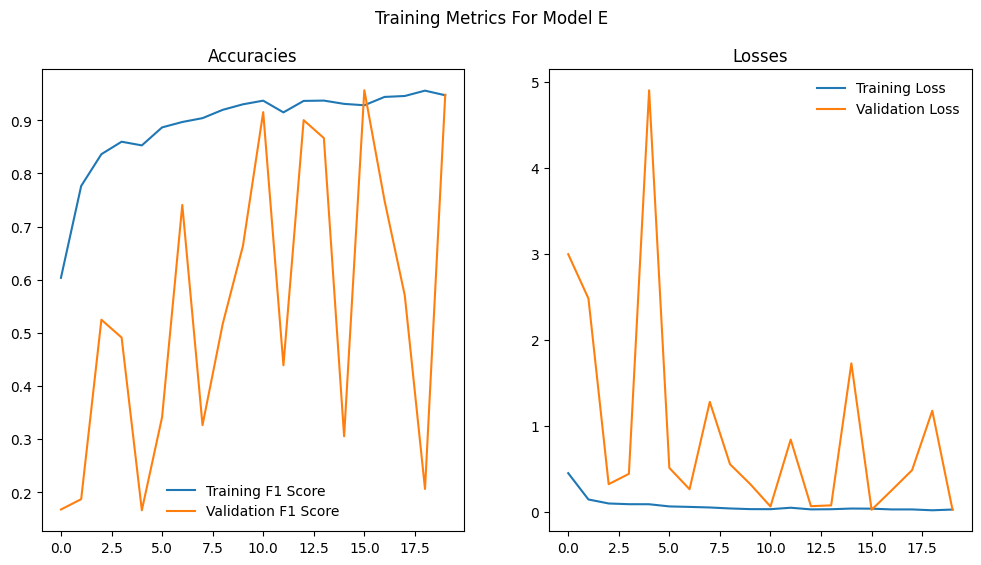

In [ ]:
history_E = train_binary_f1(model_E,'Model E',train_ds,val_ds,20,class_weight)

The loss has fallen significantly since type A and training clearly shows the dropout/batch features reducing overfitting. I expect that this model will perform best over the full training period of 100 epochs.

Evaluate on test data
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - auc: 0.3546 - f1_score: 0.2546 - loss: 0.5071
test loss, test acc: {'auc': 0.8276121616363525, 'f1_score': 0.7250781655311584, 'loss': 0.824951708316803}
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step


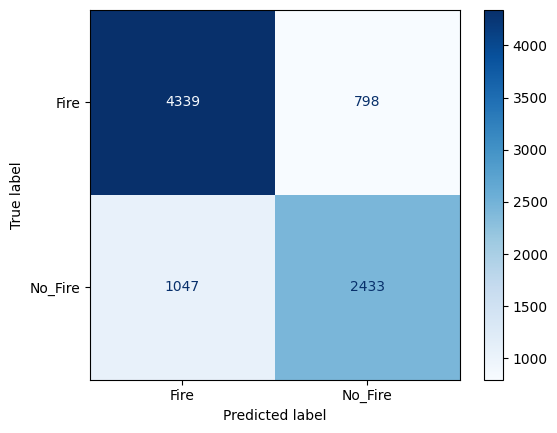

In [ ]:
binary_evaluation(raw_test_ds,class_names,model_E,0.5)

This model performs very well with the standard 0.5 threshold.

68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step


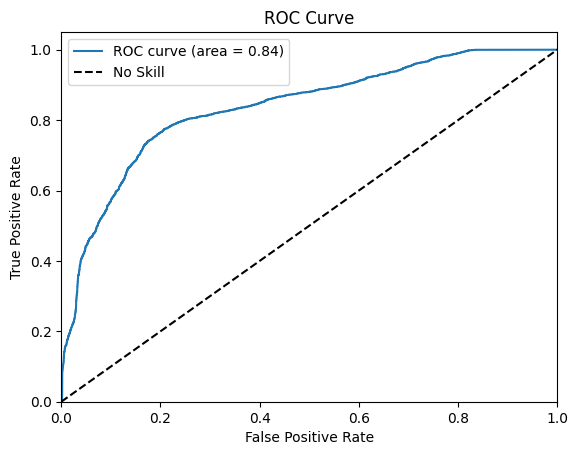

Optimal Threshold: 0.21600607


In [ ]:
plot_ROC_curve(model_E,raw_test_ds,test_labels)

Evaluate on test data
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - auc: 0.3546 - f1_score: 0.2546 - loss: 0.5071
test loss, test acc: {'auc': 0.8276121616363525, 'f1_score': 0.7250781655311584, 'loss': 0.824951708316803}
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step


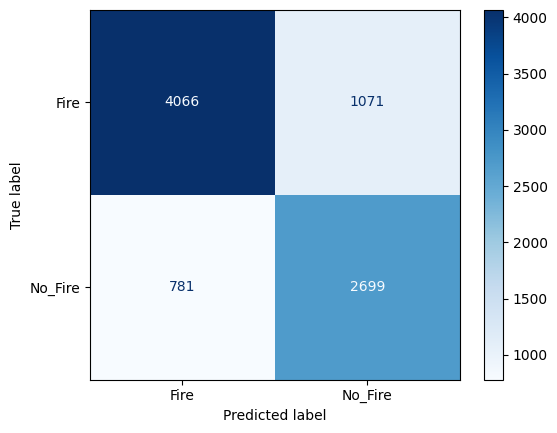

In [ ]:
binary_evaluation(raw_test_ds,class_names,model_E,0.21600607)

## **Final Model Training**

The final model will now be trained in seperate notebooks. Each notebook will have different conditions, e.g more/less augmentation and grayscaling / RGB channel modifications.

References:

[1] United States Environmental Protection Agency, “Climate Change Indicators: Wildfires | US EPA,” US EPA, Jul. 2016. https://www.epa.gov/climate-indicators/climate-change-indicators-wildfires

[2] M. W. Jones et al., “Global rise in forest fire emissions linked to climate change in the extratropics,” Science, vol. 386, no. 6719, Oct. 2024, doi: https://doi.org/10.1126/science.adl5889.

[3] Alireza Shamsoshoara, Fatemeh Afghah, Abolfazl Razi, Liming Zheng, Peter Fulé, Erik Blasch, November 19, 2020, "The FLAME dataset: Aerial Imagery Pile burn detection using drones (UAVs)", IEEE Dataport, doi: https://dx.doi.org/10.21227/qad6-r683.